In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# Baseline Code / LightGBM

In [3]:
energy = pd.read_csv('../../../data/solar_energy2/energy.csv')
dangjin_fcst = pd.read_csv('../../../data/solar_energy2/dangjin_fcst.csv')
ulsan_fcst = pd.read_csv('../../../data/solar_energy2/ulsan_fcst.csv')


In [4]:
energy.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0


In [5]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0


In [6]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667


## 학습 데이터 전처리

In [7]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LightGBM Custom Metric

In [8]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [9]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [10]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

### 당진수상태양광 예측 모델 학습

In [11]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's l1: 55.9175	valid_0's score: 8.20956


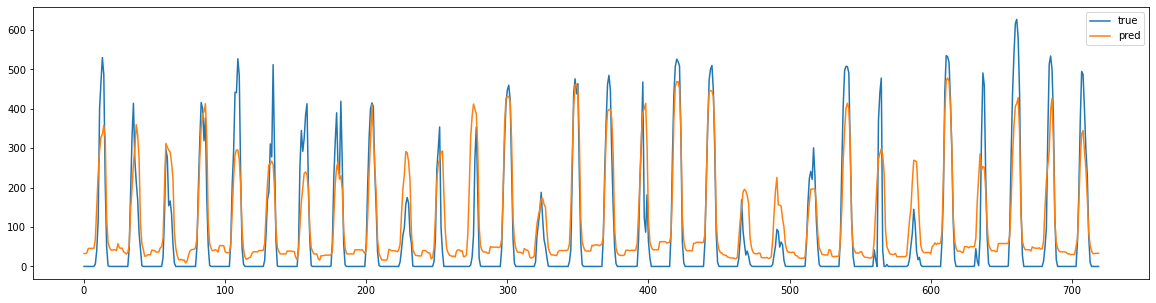

CV Score :  8.209563136470505


In [12]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진자재창고태양광 예측 모델 학습

In [13]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 11949, number of used features: 9
[LightGBM] [Info] Start training from score 193.765671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's l1: 41.3945	valid_0's score: 9.59835


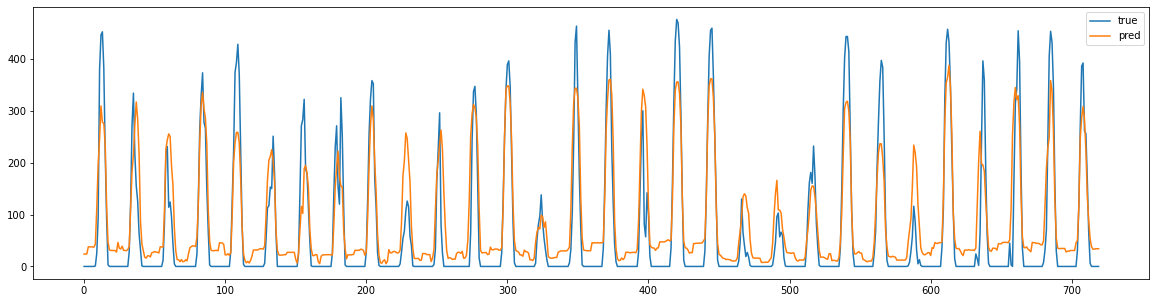

CV Score :  9.59835047558399


In [14]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 당진태양광 예측 모델 학습

In [15]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 11349, number of used features: 9
[LightGBM] [Info] Start training from score 308.414486
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's l1: 72.5186	valid_0's score: 9.86129


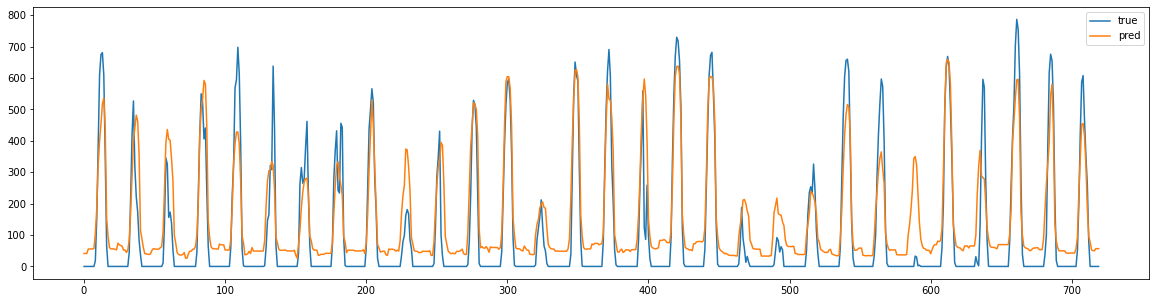

CV Score :  9.861289658630081


In [16]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 울산태양광 예측 모델 학습

In [17]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.4698	valid_0's score: 6.36286
Early stopping, best iteration is:
[609]	valid_0's l1: 15.3328	valid_0's score: 6.32718


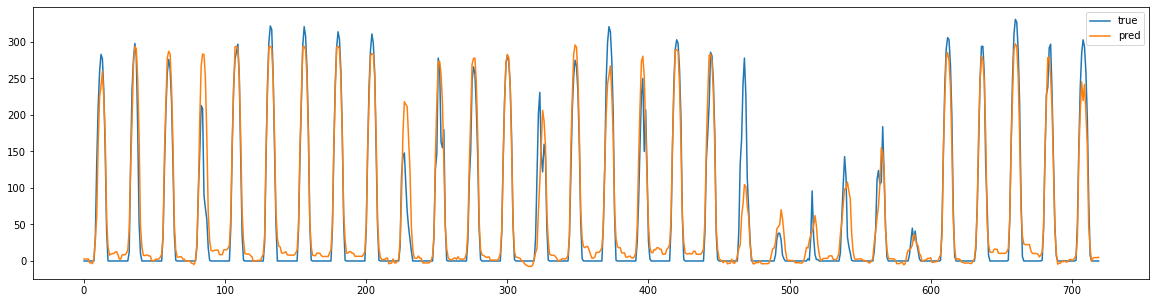

CV Score :  6.32718252135846


In [18]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

# 테스트 데이터 전처리

In [19]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [20]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

# 각 발전소 발전량 추론

In [22]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

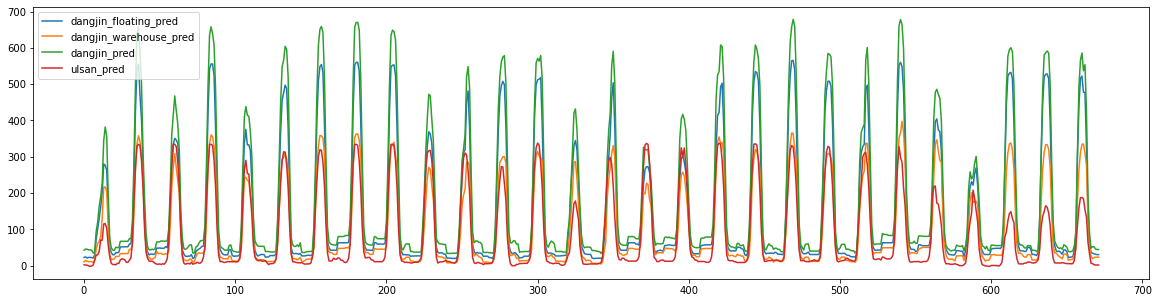

In [23]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [24]:
submission = pd.read_csv('../../../data/solar_energy2/sample_submission.csv')

submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,22.493083,10.507360,42.468316,2.334401
1,2021-02-01 02:00:00,23.985934,14.297420,45.386430,1.435847
2,2021-02-01 03:00:00,21.115239,12.079159,45.325947,1.219794
3,2021-02-01 04:00:00,22.450140,10.917043,43.367861,-0.482657
4,2021-02-01 05:00:00,22.450140,10.917043,43.367861,-2.331366
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [25]:
submission.to_csv('../../../data/solar_energy2/dacon_baseline_0418.csv', index=False)

# 계정 xian0105 (학원)
# 파일명 : dacon_baseline_0418(9.4614).csv
# score : 9.4614